# Notebook to Investigate LSTM Performance Variance by Huc Type - Assemble Metrics And Data for Test Sets

# Step 0 - Set up Notebook

In [1]:
# import needed libaries
import os
import boto3
import mlflow
import time
from PIL import Image
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from snowML.datapipe import snow_types as st
from snowML.datapipe import get_geos as gg
from snowML.datapipe import data_utils as du
from snowML.datapipe import get_dem as gd
from snowML.viz import download_metrics as dm

In [2]:
# initialize erathengine credentials
import ee
ee.Authenticate()

True

# Step1 - Get MLFlow Metrics

In [3]:
# function to extract only a specific metric
def extract_metric(df, metric_name):
    """Extracts rows where the Metric column ends with 'metric_name' and returns only Metric and Value columns."""
    return df[df['Metric'].str.endswith(metric_name)][['Metric', 'Value']].sort_values(by='Metric')

In [4]:
# function to extract data from a given epoch 
def summarize_by_step(df, step, agg_lev = 12):
    df_filtered = df[df["Step"] == step].copy()
    df_filtered["Metric_Type"] = df_filtered["Metric"].str.extract(r"(test_mse|test_kge|test_r2)")
    df_filtered["HUC_ID"] = df_filtered["Metric"].str.extract(fr"(\d{{{agg_lev}}})")  
    df_pivot = df_filtered.pivot(index="HUC_ID", columns="Metric_Type", values="Value")
    df_pivot.columns = ["Test KGE", "Test MSE", "Test_R2"]
    df_pivot_sorted = df_pivot.sort_index()
    df_selected = df_pivot_sorted[["Test MSE", "Test KGE", "Test_R2"]]
    # print(df_selected)
    return df_selected

In [5]:
# create a dictionary of run_ids 
run_dict = dm.create_run_dict_Ex3Eval()
print(run_dict)

{'Test_Set_A': 'ccc1af0a3007412bb23cbd4a7cb0d431', 'Test_Set_B': '148f7dddc0814c4f86bb93edbc425c4c'}


In [6]:
# create a dictionary of dataframes corresponding to the run_id shortname uploading from local files 
df_dict = {}
for key in run_dict.keys(): 
    run_id = run_dict[key]
    file = f"../../data/run_id_data/metrics_from_{run_id}.csv"
    df_metrics = pd.read_csv(file)
    #print(df_metrics.shape)
    df_dict[key] = df_metrics

In [7]:
# summarize results Test Set A 
df_metrics_A = df_dict["Test_Set_A"]
df_summary_A = summarize_by_step(df_metrics_A, 0)
df_summary_A.head(2)

,Test MSE,Test KGE,Test_R2
HUC_ID,,,
170103020201,0.001897,0.841758,0.924090
170103020301,0.000845,0.924311,0.917509


In [16]:
df_summary_A.describe()

,Test MSE,Test KGE,Test_R2
count,54.000000,54.000000,54.000000
mean,0.007387,0.723357,0.820370
std,0.012596,0.311120,0.372874
min,0.000522,-0.614623,-1.173180
25%,0.001691,0.635164,0.846439
50%,0.004524,0.845155,0.931609
75%,0.007354,0.900350,0.957855
max,0.087530,0.982700,0.986104


In [8]:
# summarize results Test Set B 
df_metrics_B = df_dict["Test_Set_B"]
df_summary_B = summarize_by_step(df_metrics_B, 0)
df_summary_B.head(2)

,Test MSE,Test KGE,Test_R2
HUC_ID,,,
170300010101,0.011511,0.784917,0.935723
170300010102,0.018615,0.710050,0.900482


In [17]:
df_summary_B.describe()

,Test MSE,Test KGE,Test_R2
count,48.000000,48.000000,48.000000
mean,0.007014,0.789205,0.887679
std,0.008653,0.145063,0.076185
min,0.000222,0.265396,0.550655
25%,0.002085,0.706568,0.863799
50%,0.004246,0.821192,0.918686
75%,0.008932,0.883383,0.934607
max,0.050682,0.969418,0.963966


# Step 2 - Plot histogram of test_kge 

In [9]:
def plot_test_kge_histogram(df, title = "histogram"):
    """
    Plots a histogram of the test_kge values from a pandas DataFrame and saves it as 'histogram.png'.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing the column 'test_kge'.
    """
    if 'Test KGE' not in df.columns:
        raise ValueError("DataFrame must contain a 'Test KGE' column")
    
    test_kge_values = df['Test KGE'].dropna()
    median_kge = np.median(test_kge_values)
    
    plt.figure(figsize=(8, 6))
    plt.hist(df['Test KGE'].dropna(), bins=20, edgecolor='black', alpha=0.7)
    plt.axvline(median_kge, color='red', linestyle='dashed', linewidth=2, label=f'Median: {median_kge:.2f}')
    plt.text(median_kge, plt.ylim()[1] * 0.9, f'Median: {median_kge:.2f}', color='red', ha='right', fontsize=12, fontweight='bold')
    plt.xlabel('Test KGE')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    output_file = f"charts/{title}.png"
    plt.savefig(output_file)
    plt.show()
    plt.close()
    return plt


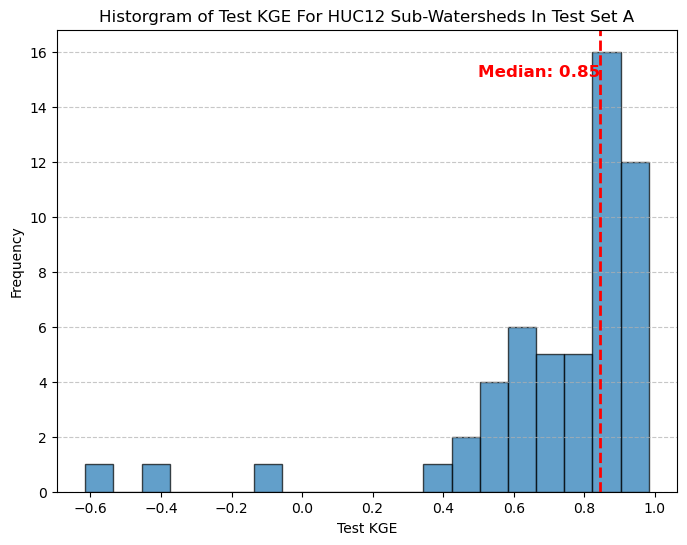

<module 'matplotlib.pyplot' from '/home/suetboyd/miniconda3/lib/python3.11/site-packages/matplotlib/pyplot.py'>

In [10]:
plot_test_kge_histogram(df_summary_A, title = "Historgram of Test KGE For HUC12 Sub-Watersheds In Test Set A")

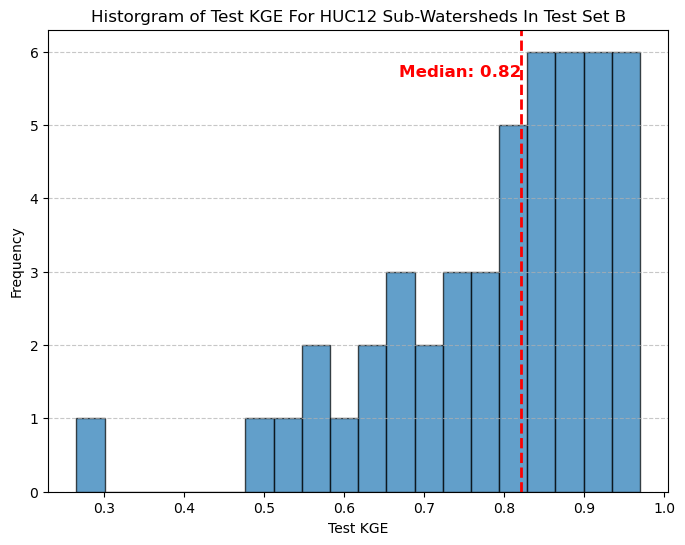

<module 'matplotlib.pyplot' from '/home/suetboyd/miniconda3/lib/python3.11/site-packages/matplotlib/pyplot.py'>

In [11]:
plot_test_kge_histogram(df_summary_B, title = "Historgram of Test KGE For HUC12 Sub-Watersheds In Test Set B")


## Step 3 Add in Snow Class Data 

In [12]:
def get_snow_type_data(huc_list): 
    df_dict = {}
    count = 0
    time_start = time.time()
    input_pairs = [[huc, '12'] for huc in huc_list]
    for input_pair in input_pairs: 
        count += 1
        _, _, df_predom = st.process_all(input_pair[0], input_pair[1])
        df_dict[input_pair[0]] = df_predom
        if count % 20 == 0: 
            print(f"Finished processing huc {count} out of {len(huc_list)}")
            du.elapsed(time_start)
    print("all done")
    return df_dict



In [13]:
def combine_dfs(df_dict): 
    df_list = []
    for huc_id, df in df_dict.items():
        df_list.append(df)
    df_snow_types = pd.concat(df_list)
    df_snow_types = df_snow_types.set_index("huc_id")
    df_snow_types = df_snow_types[["Predominant_Snow"]]
    df_snow_types["color_snow_type"] = df_snow_types["Predominant_Snow"].map(color_map).fillna("white")
    return df_snow_types 

In [14]:
# Define color mapping
color_map = {
    "Ephemeral": "blue",
    "Maritime": "yellow",
    "Montane Forest": "orange"
}

In [15]:
# call the functions to append snow types - Test Set A 
hucs_A = list(df_summary_A.index)
df_dict_A = get_snow_type_data(hucs_A)
df_st_A = combine_dfs(df_dict_A)
print(df_st_A.shape)
df_st_A.head(2)
df_merged_A = df_st_A.merge(df_summary_A, left_index=True, right_index=True)



Finished processing huc 20 out of 54
______Elapsed time is 35 seconds
Finished processing huc 40 out of 54
______Elapsed time is 66 seconds



KeyboardInterrupt



In [ ]:
# repeat for Test Set B 
hucs_B = list(df_summary_B.index)
df_dict_B = get_snow_type_data(hucs_B)
df_st_B = combine_dfs(df_dict_B)
print(df_st_B.shape)
df_st_B.head(2)
df_merged_B = df_st_B.merge(df_summary_B, left_index=True, right_index=True)

In [ ]:
# Step 5 Add in Basin Geometries & Mean elevation 

In [ ]:
def add_geos_and_dem(df): 
    time_start = time.time()
    count = 0 
    results = df.copy()
    for huc_id in list(df.index):
        count += 1
        geos = gg.get_geos_with_name(huc_id, '12')
        #print(geos.iloc[0]["name"])
        results.loc[results.index == huc_id, "Name"] = geos.iloc[0]["name"]
        results.loc[results.index == huc_id, "geometry"] = geos.iloc[0]["geometry"]
        dem_ds = gd.get_dem(geos)
        #print("done getting dem")
        mean_elev = gd.calc_mean_dem(dem_ds)
        results.loc[results.index == huc_id, "mean_elevation"] = mean_elev
        if  count % 10 == 0: 
            print(f"finished processing huc {count} out of {len(df.index)}")
            du.elapsed(time_start)
    results_gdf = gpd.GeoDataFrame(results, geometry="geometry")
    results_gdf.set_crs("EPSG:4326", inplace=True) 
    col_to_kp = ["Name", "Test MSE", "Test KGE", "Test_R2", "Predominant_Snow", "color_snow_type", "mean_elevation", "geometry"]
    return results_gdf[col_to_kp]
        

In [ ]:
gdf_A = add_geos_and_dem(df_merged_A)
gdf_A.head(2)

In [ ]:
gdf_B = add_geos_and_dem(df_merged_B)
gdf_B.head(2)

In [ ]:
gdf_A.explore(color=gdf_A['color_snow_type'], legend=True)

In [ ]:
gdf_B.explore(color=gdf_B['color_snow_type'], legend=True)

In [ ]:
# Step 7 - Add an elevation categorization 

In [ ]:
# Define the bins and corresponding labels
bins = [0, 500, 1000, 1500, 2000, float('inf')]
labels = ['low', 'lower mid', 'mid', 'upper mid', 'high']

In [ ]:
# Create the new column 'Elevation Category' based on 'mean_elevation'
gdf_A['Elevation Category'] = pd.cut(gdf_A['mean_elevation'], bins=bins, labels=labels, right=False)
gdf_A.head(2)


In [ ]:
# Repeat for Test Set B 
# Create the new column 'Elevation Category' based on 'mean_elevation'
gdf_B['Elevation Category'] = pd.cut(gdf_B['mean_elevation'], bins=bins, labels=labels, right=False)
gdf_B.head(2)

In [ ]:
# Step Last Save Files

In [ ]:
# save the combined data to a local_file
f_A = "TestA__metrics_w_snow_types_and_elev.csv"
gdf_A.to_csv(f_A, index = True)
f_B = "TestB__metrics_w_snow_types_and_elev.csv"
gdf_B.to_csv(f_B, index = True)